In [ ]:
import pandas as pd
df = pd.read_csv("Amazon_SentimentAnalysis.csv")

In [ ]:
from sklearn.model_selection import train_test_split

X = df_cleaned["cleaned_review"]
y = df_cleaned["sentiment"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .25, random_state = 42)
print(X_train.shape)
print(X_val.shape)

(3000,)
(1000,)


In [ ]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize)
X_train = tfidf.fit_transform(X_train)
X_val = tfidf.transform(X_val)

### Baseline Model - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, roc_auc_score

y_pred = rf.predict(X_val)
acc = accuracy_score(y_pred, y_val)
report = classification_report(y_val, y_pred)
roc = roc_auc_score(y_val,y_pred)

print(f"Accuracy:", round(acc, 3), "Roc Auc Score: ", round(roc, 3))
print(report)

Accuracy: 0.761 Roc Auc Score:  0.761
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       504
           1       0.75      0.78      0.76       496

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



### Bidirectional LSTM

In [ ]:
X = df["cleaned_review"]
y = df["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)
print(X_train.shape)
print(X_test.shape)

(3000,)
(1000,)


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train_seq_pad = pad_sequences(X_train_seq, maxlen=64)
X_test_seq_pad = pad_sequences(X_test_seq, maxlen=64)
X_train_seq_pad

array([[    0,     0,     0, ...,   600,   496,   884],
       [    0,     0,     0, ...,   728,  1010,    84],
       [    0,     0,     0, ...,     7,   185,   122],
       ...,
       [    0,     0,     0, ...,    98,     2,    56],
       [16073,     7,  4189, ...,    14,    89,  3800],
       [    0,     0,     0, ...,    20,    25,    23]], dtype=int32)

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, LSTM, Bidirectional, Dropout

BATCH_SIZE = 32

model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1,64))
model.add(Bidirectional(LSTM(100, dropout=0.9,recurrent_dropout=0)))
model.add(Dense(128, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile("rmsprop","binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 64)          1029376   
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              132000    
 nal)                                                            
                                                                 
 dense_30 (Dense)            (None, 128)               25728     
                                                                 
 dense_31 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,187,233
Trainable params: 1,187,233
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss",patience=5,verbose=True)

In [ ]:
history = model.fit(X_train_seq_pad, y_train,batch_size=BATCH_SIZE, epochs=20,
                    validation_data=(X_test_seq_pad, y_test), callbacks=[early_stop])

Epoch 1/20
94/94 [==============================] - 23s 154ms/step - loss: 0.6923 - accuracy: 0.5173 - val_loss: 0.6746 - val_accuracy: 0.6520
Epoch 2/20
94/94 [==============================] - 11s 121ms/step - loss: 0.6305 - accuracy: 0.6580 - val_loss: 0.5599 - val_accuracy: 0.7310
Epoch 3/20
94/94 [==============================] - 12s 123ms/step - loss: 0.5443 - accuracy: 0.7190 - val_loss: 0.5106 - val_accuracy: 0.7630
Epoch 4/20
94/94 [==============================] - 12s 126ms/step - loss: 0.4953 - accuracy: 0.7593 - val_loss: 0.5128 - val_accuracy: 0.7430
Epoch 5/20
94/94 [==============================] - 16s 167ms/step - loss: 0.4488 - accuracy: 0.7913 - val_loss: 0.4734 - val_accuracy: 0.7790
Epoch 6/20
94/94 [==============================] - 15s 156ms/step - loss: 0.4041 - accuracy: 0.8240 - val_loss: 0.4563 - val_accuracy: 0.7920
Epoch 7/20
94/94 [==============================] - 11s 115ms/step - loss: 0.3678 - accuracy: 0.8403 - val_loss: 0.4579 - val_accuracy: 0.7960

In [ ]:
from sklearn.metrics import roc_auc_score

pred_train = model.predict(X_train_seq_pad)
pred_test = model.predict(X_test_seq_pad)
print('LSTM Train: ' + str(roc_auc_score(y_train, pred_train)))
print('LSTM Test: ' + str(roc_auc_score(y_test, pred_test)))

LSTM Train: 0.9937386666666668
LSTM Test: 0.886780753968254


In [ ]:
model.evaluate(X_test_seq_pad, y_test)

32/32 [==============================] - 1s 27ms/step - loss: 0.5452 - accuracy: 0.7940


[0.5452129244804382, 0.7940000295639038]

Text(0.5, 1.0, 'Training and Validation Accuracy')

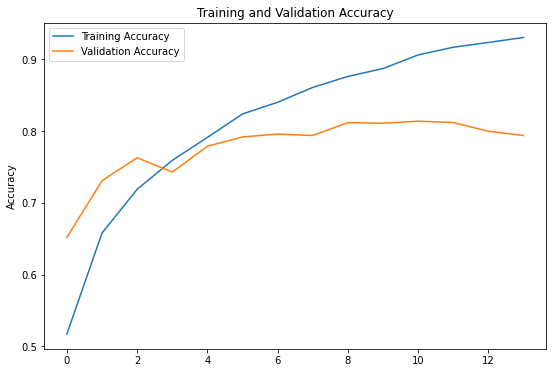

In [ ]:
acc = history.history["accuracy"]
loss = history.history["loss"]

val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(9,6))
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc,label="Validation Accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")


Text(0.5, 1.0, 'Training and Validation Loss')

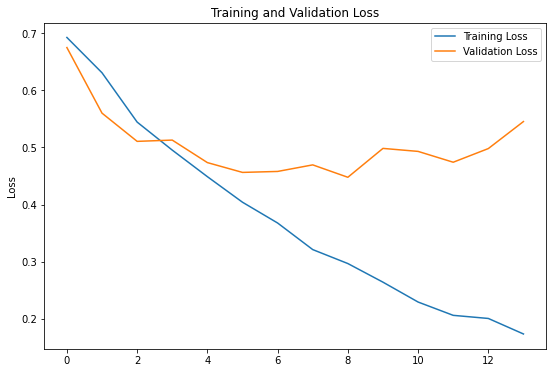

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(loss,label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

## GRU

In [ ]:
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1,64))
model.add(GRU(100, dropout = 0.9))
model.add(Dense(128, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, None, 64)          1029376   
                                                                 
 gru_12 (GRU)                (None, 100)               49800     
                                                                 
 dense_32 (Dense)            (None, 128)               12928     
                                                                 
 dense_33 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,092,233
Trainable params: 1,092,233
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(monitor="val_loss",patience=5,verbose=True)

In [ ]:
history = model.fit(X_train_seq_pad, y_train,batch_size=BATCH_SIZE, epochs=20,
                    validation_data=(X_test_seq_pad, y_test), callbacks=[early_stop])

Epoch 1/20
94/94 [==============================] - 10s 75ms/step - loss: 0.6929 - acc: 0.5107 - val_loss: 0.6886 - val_acc: 0.5720
Epoch 2/20
94/94 [==============================] - 6s 68ms/step - loss: 0.6666 - acc: 0.5867 - val_loss: 0.5907 - val_acc: 0.7170
Epoch 3/20
94/94 [==============================] - 6s 64ms/step - loss: 0.5733 - acc: 0.7010 - val_loss: 0.5398 - val_acc: 0.7350
Epoch 4/20
94/94 [==============================] - 7s 73ms/step - loss: 0.5133 - acc: 0.7423 - val_loss: 0.4945 - val_acc: 0.7570
Epoch 5/20
94/94 [==============================] - 6s 69ms/step - loss: 0.4544 - acc: 0.7907 - val_loss: 0.4690 - val_acc: 0.7890
Epoch 6/20
94/94 [==============================] - 7s 73ms/step - loss: 0.4179 - acc: 0.8140 - val_loss: 0.4718 - val_acc: 0.7810
Epoch 7/20
94/94 [==============================] - 11s 122ms/step - loss: 0.3922 - acc: 0.8287 - val_loss: 0.4767 - val_acc: 0.7780
Epoch 8/20
94/94 [==============================] - 11s 117ms/step - loss: 0.366

In [ ]:
pred_train = model.predict(X_train_seq_pad)
pred_test = model.predict(X_test_seq_pad)
print('GRU Train: ' + str(roc_auc_score(y_train, pred_train)))
print('GRU Test: ' + str(roc_auc_score(y_test, pred_test)))

GRU Train: 0.9855822222222222
GRU Test: 0.8881448412698413


In [ ]:
model.evaluate(X_test_seq_pad, y_test)

32/32 [==============================] - 1s 20ms/step - loss: 0.5037 - acc: 0.8180


[0.5036537051200867, 0.8180000185966492]

Text(0.5, 1.0, 'Training and Validation Accuracy')

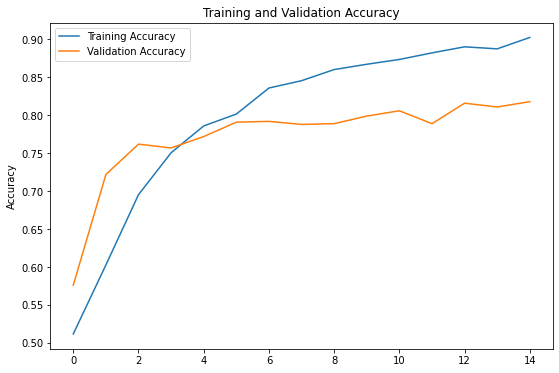

In [ ]:
acc = history.history["acc"]
loss = history.history["loss"]

val_acc = history.history["val_acc"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(9,6))
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc,label="Validation Accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")


Text(0.5, 1.0, 'Training and Validation Loss')

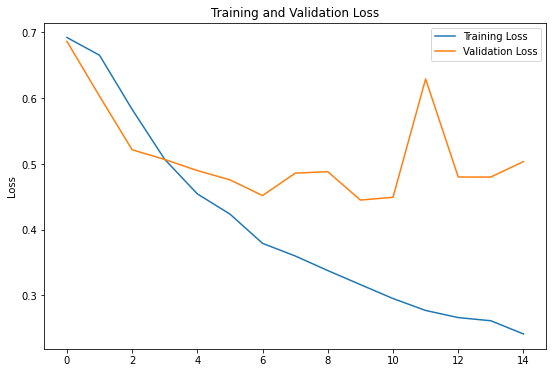

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(loss,label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

**Result**

The GRU model has a slightly better accuracy score with .82 than the LSTM accuracy score with .79. 

However, there seems an issue with overfitting so further regularization is neccessary for the future study. 

**Further Development**

Turning more hyperparameter

*   Other activation functions
*   Optimizer (i.e., Mini Batch Gradient Descent)


